# ============================================================
# Задание 8
# ============================================================
**Анализ временных рядов**

*Зуева Надежда, 594 группа*

**Задание:**
1. Нарисуйте графики временных рядов температуры и потребления электричества. Верно ли, что спрос на электричество зависит от температуры воздуха? Для ответа на вопрос используйте коэффициенты корреляции, учитывая условия их применимости.
2. Разделите временной ряд на две части: данные за последнюю неделю (последние 48*7 измерений) назовем тестовыми данными, а все остальное — обучающими данными.

3. Сколько типов сезонностей можно выделить в каждом из двух рядов (спрос на электричество и температура)? С помощью STL-декомпозиции в каждом ряде выделите тренд, все типы сезонности, остатки.

4. С помощью критерия KPSS проверьте на стационарность исходные ряды и остатки, полученные после применения STL-декомпозиции. Не забывайте про множественную проверку гипотез.

5. С помощью преобразований исходных рядов приведите их к стационарным. По графикам ACF и PACF подберите параметры модели SARIMA.

6. С помощью поиска по сетке вокруг выбранных параметров подберите оптимальные параметры по значению AIC. Учтите, что из сделанных ранее преобразований ряда нужно оставить лишь некоторые. Другие, например, одна из сезонностей будут учтены параметрами модели.

7. Постройте прогнозы модели с оптимальными параметрами на неделю вперед. Посчи- тайте качество прогноза по сравнению с реальными данными на тестовом интервале, используя метрику MSE (см. презентацию).

8. Добавьте в модель предсказания электричества экзогенные факторы:
    (a) Дневную и месячную сезонность (очевидно, они известны заранее). Однако, в том виде как они записаны в таблице применять не хорошо — может работать плохо, поэтому стоит использовать гармоники Фурье — синусы с периодом, де- лящим период сезонности. Их использование может позволить учесть сложные сезонности.
    (b) Значения температуры, используя на тестовом интервале времени истинные зна- чения температуры (нечестный способ).
    (c) Значения температуры, используя на тестовом интервале времени предсказания значений температуры.
    (d) Вместе (a) и (c).
    (e) * Использование значений температуры по частям — для получения прогноза
    
9. Сравните все предсказания по метрике MSE.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import scipy.stats as sps
import warnings
import itertools
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import statsmodels.api as sm
import statsmodels
%matplotlib inline
plt.style.use('fivethirtyeight')

### Часть 1
**Нарисуйте графики временных рядов температуры и потребления электричества. Верно ли, что спрос на электричество зависит от температуры воздуха? Для ответа на вопрос используйте коэффициенты корреляции, учитывая условия их применимости.**

Прочитаем данные из датасета

#### ====================================
В файле electricity.csv (отсюда) cодержится информация о максимальном спросе на
электричество (Consumption) в штате Виктория (Австралия) за 30-минутные интервалы с 10 января 2000 в течениe 115 дней, а так же информация о температуре воздуха
(Temperature) за эти же промежутки времени

In [2]:
from copy import copy

data_ = pd.read_csv("electricity.csv")
data_ = data_.fillna(data_.bfill())
data = copy(data_)
Time=copy(data.Time)

In [3]:
import dateutil.parser
from dateutil.tz import tzoffset, tzlocal
from datetime import datetime, timedelta
def parse_data(time):
    start=datetime.strptime( "2000-01-10 00:00:00", "%Y-%m-%d %H:%M:%S" )
    for i in tqdm.tqdm(range(len(time))):
        b = timedelta(days=0, hours=0.5*i, seconds=0)
        time[i]=str(start+b)
    return pd.core.series.Series(time)
print(type(data.Time))

<class 'pandas.core.series.Series'>


In [4]:
print(data.Time[5000])
data.Time=copy(Time)

5000


***Выведем начальные строки:***

In [5]:
data.head(10)

,Id,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
0,0,3853.475392,20.90,0,0,48
1,1,3683.014105,20.70,1,1,49
2,2,3912.324031,20.50,2,2,50
3,3,3783.881181,20.05,3,3,51
4,4,3554.257244,19.60,4,4,52
5,5,3362.243384,19.20,5,5,53
6,6,3240.526735,18.80,6,6,54
7,7,3187.438715,18.45,7,7,55
8,8,3220.471434,18.10,8,8,56
9,9,3298.803565,18.00,9,9,57


***Конец входа:***

In [6]:
data.tail(10)

,Id,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
5510,5510,5038.608967,15.10,5510,38,182
5511,5511,4960.149700,15.00,5511,39,183
5512,5512,4853.335809,14.90,5512,40,184
5513,5513,4743.056450,14.85,5513,41,185
5514,5514,4548.409191,14.80,5514,42,186
5515,5515,4410.631913,14.70,5515,43,187
5516,5516,4292.029885,14.60,5516,44,188
5517,5517,4231.380523,14.65,5517,45,189
5518,5518,4587.536047,14.70,5518,46,190
5519,5519,4540.230041,14.75,5519,47,191


***Конец входа:***

In [9]:
print(type(data.Time), type(data.Consumption))
np.polyfit(data.Time,data.Consumption,deg=1)

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


array([ -5.68756323e-02,   4.42721917e+03])

*Теперь построим графики временных рядов для температуры и потребления электричества:*

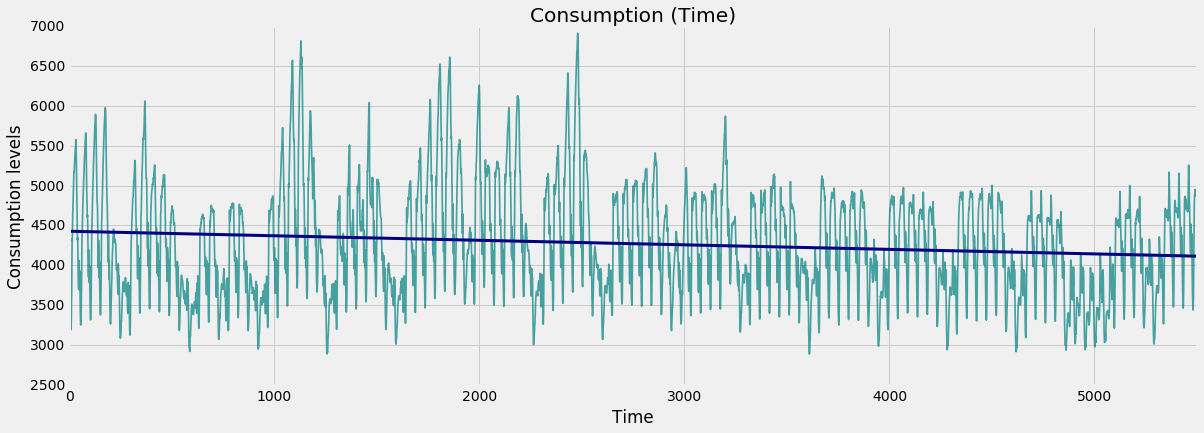

In [8]:
data_Cons = data.Consumption+data.Time
plt.figure(figsize=(18, 6))
plt.plot(data.Time,data.Consumption,color='teal',alpha=0.7, linewidth=1.7)
plt.plot(data.Time,-5.68756323*10**(-2)*data.Time+4.42721917*1000, linewidth=3,color='navy')
plt.plot(linewidth=1)
plt.title("Consumption (Time)")
plt.ylabel('Consumption levels')
plt.xlim(0,5500)
plt.xlabel("Time")
plt.show()


In [9]:
np.polyfit(np.array(data.Time),np.array(data.Temperature),deg=1)

array([ -1.32481746e-03,   2.36720928e+01])

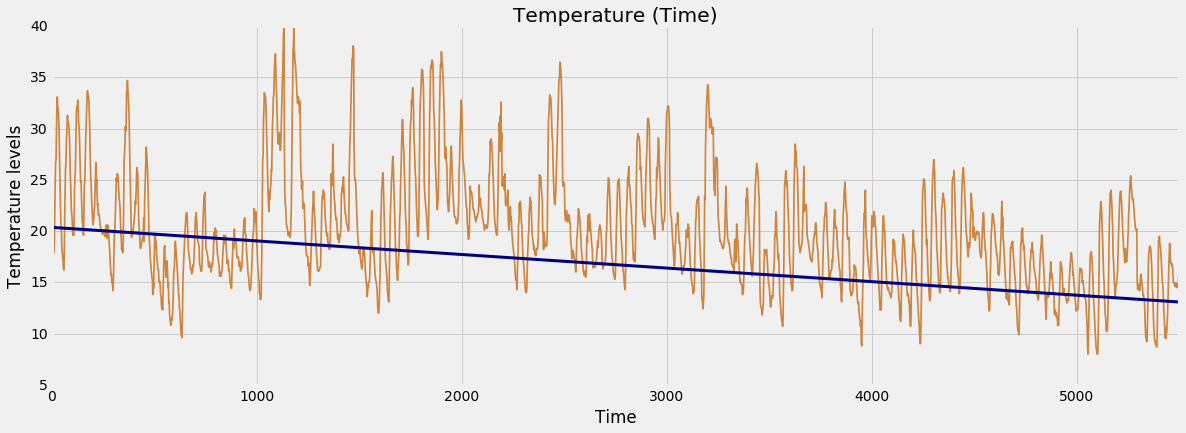

In [10]:
plt.figure(figsize=(18, 6))
plt.plot(data.Time,data.Temperature,color='peru',linewidth=1.7)
plt.plot(np.array(data.Time),np.array(-1.32481746*10**(-3)*data.Time+20.36720928),linewidth=3,color='navy')
plt.title("Temperature (Time)")
plt.ylabel('Temperature levels')
plt.xlabel("Time")
plt.xlim(0,5500)
plt.show()


Верно ли, что спрос на электричество зависит от температуры воздуха? Для ответа на вопрос используем коэффициенты корреляции, учитывая условия их применимости.

In [11]:
sps.spearmanr(data.Temperature, data.Consumption)

SpearmanrResult(correlation=0.57805418606949333, pvalue=0.0)

In [12]:
sps.pearsonr(data.Temperature, data.Consumption)

(0.6665582601612684, 0.0)

In [13]:
sps.kendalltau(data.Temperature, data.Consumption)

KendalltauResult(correlation=0.41337814259124339, pvalue=0.0)

Выходит, что, согласно данным, спрос на электроэнергию **не зависит** от температуры (вероятность ошибки первого рода -- нулевая).

### Часть 2
Разделите временной ряд на две части: данные за последнюю неделю (последние 48*7 измерений) назовем тестовыми данными, а все остальное — обучающими данными.

In [14]:
Test_Data=data[5519-48*7:5519]

In [15]:
Test_Data.head(1)

,Id,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
5183,5183,4317.386273,14.75,5183,47,191


In [16]:
Learn_Data=data[0:5519-48*7]

In [17]:
Learn_Data.tail(1)

,Id,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
5182,5182,4330.536516,15.2,5182,46,190


### Часть 3

***Сколько типов сезонностей можно выделить в каждом из двух рядов (спрос на электричество и температуру)? С помощью STL-декомпозиции в каждом ряде выделите тренд, все типы сезонности, остатки.***

### Стационарность. Удаление линии тренда.
**TODO**: критерий КПСС, линия тренда на рисунке

In [18]:
Learn_Data_Cons=pd.DataFrame({'Time':Learn_Data.Time, 'Consumption':Learn_Data.Consumption})
print(Learn_Data_Cons.head(10))
Learn_Data_Temp=pd.DataFrame({'Time':Learn_Data.Time, 'Temperature':Learn_Data.Temperature})
print('================================')
print(Learn_Data_Temp.tail(10))

   Consumption  Time
0  3853.475392     0
1  3683.014105     1
2  3912.324031     2
3  3783.881181     3
4  3554.257244     4
5  3362.243384     5
6  3240.526735     6
7  3187.438715     7
8  3220.471434     8
9  3298.803565     9
      Temperature  Time
5173        20.85  5173
5174        20.50  5174
5175        19.15  5175
5176        17.80  5176
5177        17.50  5177
5178        17.20  5178
5179        16.65  5179
5180        16.10  5180
5181        15.65  5181
5182        15.20  5182


##### Продифференциируем ряды и посмотрим на графики.

*Cначала для потребления:*

In [19]:
Learn_Data_Cons.Consumption=pd.core.series.Series(Learn_Data_Cons.Consumption[i + 1] - 
                               Learn_Data_Cons.Consumption[i] for i in range(len(Learn_Data_Cons) - 1))
Learn_Data_Cons = Learn_Data_Cons[np.isfinite(Learn_Data_Cons['Consumption'])]

In [20]:
type(Learn_Data_Cons.Consumption)

pandas.core.series.Series

In [21]:
t = np.array(Learn_Data_Cons.Time)
c = np.array(Learn_Data_Cons.Consumption)
print(t)
print('========================')
print(c)
print(np.polyfit(t,c,deg=1))
print(t.size, c.size)

[   0    1    2 ..., 5179 5180 5181]
[-170.46128667  229.30992533 -128.44285    ..., -108.005862    -55.35963533
  362.02384867]
[ -8.08136043e-05   3.01408839e-01]
5182 5182


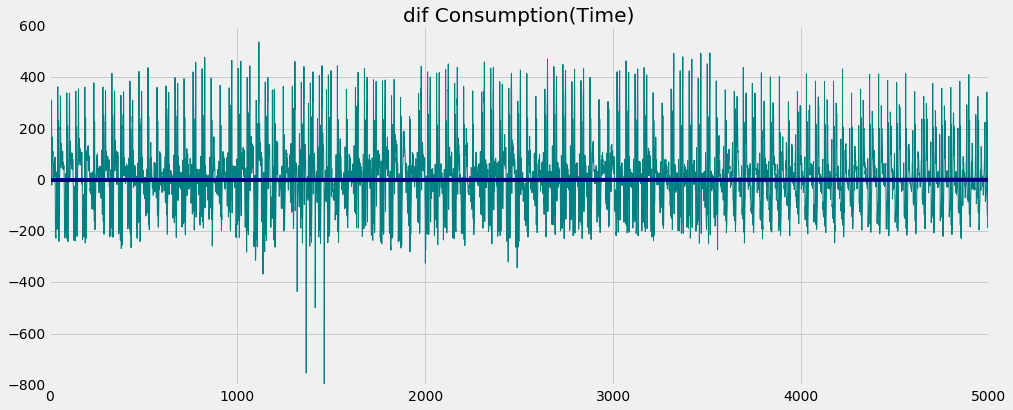

In [22]:
plt.figure(figsize=(15, 6))
plt.plot(Learn_Data_Cons.Time, Learn_Data_Cons.Consumption,color='teal',linewidth=1)
c=Learn_Data_Cons.Time
plt.xlim(0,5000)
plt.plot(c,1.82713485*10**(-4)*c-0.469736517, color='navy')
plt.title("dif Consumption(Time)")
plt.show()

#### Стационарно!
Впрочем, в конце мы это проверим с помощью критерия.
Проведем аналогичные рассуждения для **температуры.**

In [23]:
Learn_Data_Temp.Temperature=pd.core.series.Series(Learn_Data_Temp.Temperature[i + 1] - 
                               Learn_Data_Temp.Temperature[i] for i in range(len(Learn_Data_Temp) - 1))
Learn_Data_Temp = Learn_Data_Temp[np.isfinite(Learn_Data_Temp['Temperature'])]

In [24]:
t = np.array(Learn_Data_Temp.Time)
c = np.array(Learn_Data_Temp.Temperature)
print(t)
print('========================')
print(c)
print(np.polyfit(t,c,deg=1))
print(t.size, c.size)

[   0    1    2 ..., 5179 5180 5181]
[-0.2  -0.2  -0.45 ..., -0.55 -0.45 -0.45]
[ -9.88869197e-07   1.46170425e-03]
5182 5182


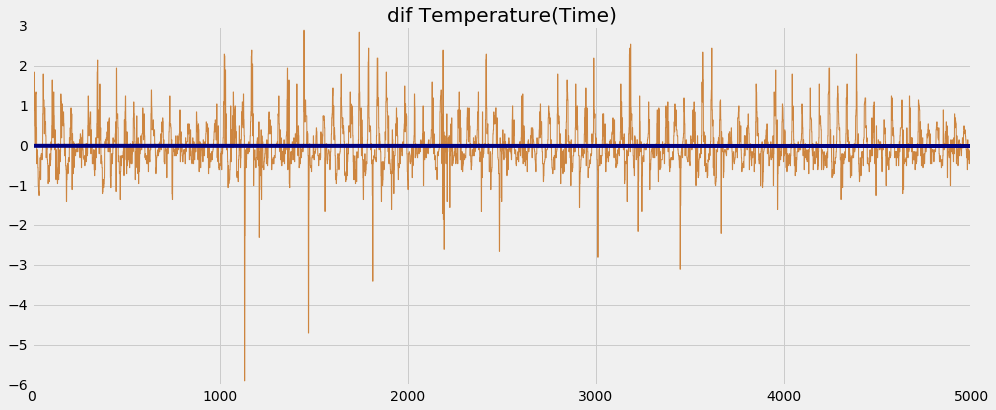

In [25]:
plt.figure(figsize=(15, 6))
plt.plot(Learn_Data_Temp.Time, Learn_Data_Temp.Temperature,color='peru',linewidth=1)
c=Learn_Data_Temp.Time
plt.xlim(0,5000)
plt.plot(c,-9.88869197*10**(-7)*c-1.46170425*10**(-3), color='navy')
plt.title("dif Temperature(Time)")
plt.show()

Проверим ряд на стационарность с помощью **критерия KPSS**: 

In [26]:
statsmodels.tsa.stattools.kpss(Learn_Data_Cons.Consumption)

(0.0047410270156470332,
 0.1,
 33,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

In [27]:
statsmodels.tsa.stattools.kpss(Learn_Data_Temp.Temperature)

(0.0053929294711484548,
 0.1,
 33,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

Итак, наши ряды стали ***стационарными.*** (в силу значений **p-value**)

In [28]:
def Draw_autcorrelation(y,c):
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(y, lags=50, ax=ax1,color=c)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsaplot_pacf(y, lags=50, ax=ax2,color=c)
    plt.show()

Consumption


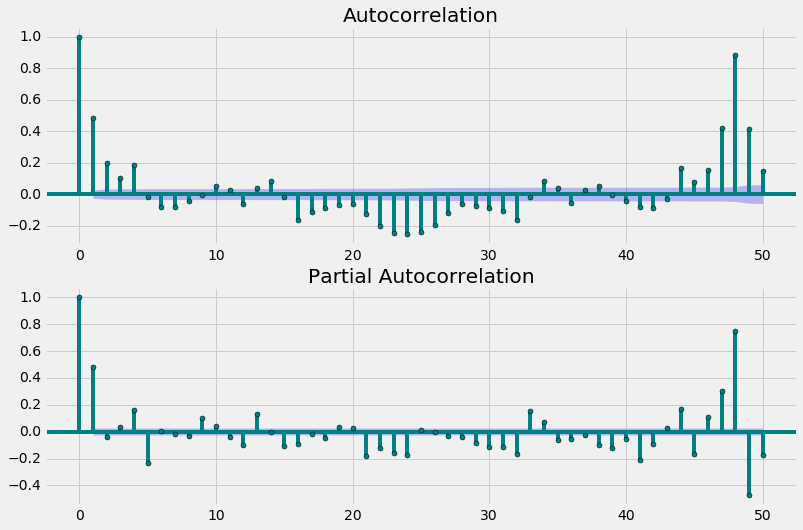

Temperature


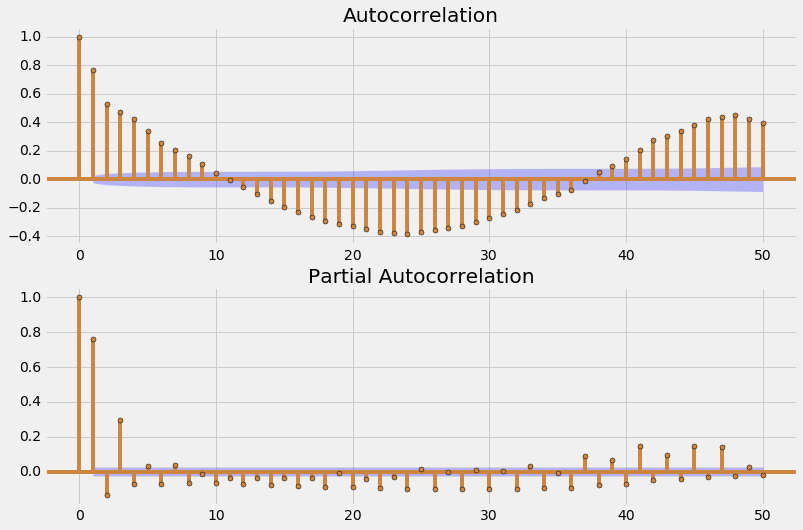

In [29]:
print("Consumption")
Draw_autcorrelation(Learn_Data_Cons.Consumption,'teal')
print("Temperature")
Draw_autcorrelation(Learn_Data_Temp.Temperature,'peru')

### Вывод: 
по температуре видна **ОЧЕНЬ** четкая сезонность, напоминающая синусоиду. Сезонность по потреблению также хорошо просматривается. 
Уберем их.

## Часть 4
### Сезонность
Начнем с потребления и затем выполним аналогичные действия для температуры.

Рассмотрим внимательнее график и постараемся угадать период. Будет следить за ***коррелограммой.***
Предполагается что **температура** зависит только от времени суток, а **потребление** и от времени суток, и от дня недели.

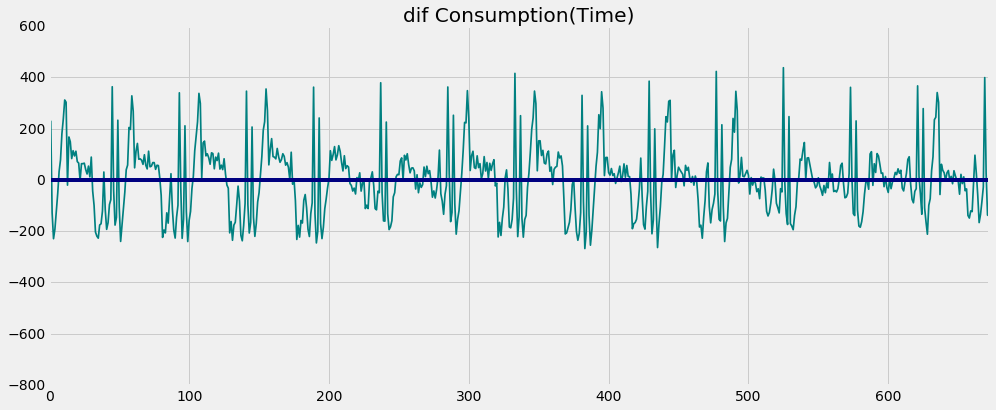

In [30]:
plt.figure(figsize=(15, 6))
plt.plot(Learn_Data_Cons.Time, Learn_Data_Cons.Consumption,color='teal',linewidth=1.7)
c=Learn_Data_Cons.Time
plt.xlim(0,48*14)
plt.plot(c,1.82713485*10**(-4)*c-0.469736517, color='navy')
plt.title("dif Consumption(Time)")
plt.show()

Похоже, что период составляет примерно ***48 единиц***, что в нашем случае соотвествует суткам. Продиффиренциируем по этой величине:

In [31]:
Learn_Data_Cons.Consumption=pd.core.series.Series(Learn_Data_Cons.Consumption[i + 48] - 
                               Learn_Data_Cons.Consumption[i] for i in range(len(Learn_Data_Cons) - 48))
Learn_Data_Cons = Learn_Data_Cons[np.isfinite(Learn_Data_Cons['Consumption'])]

Consumption


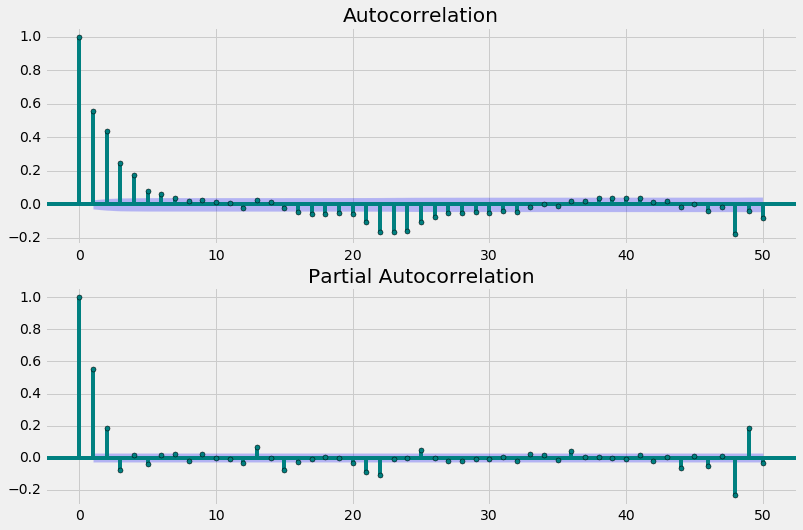

In [32]:
print("Consumption")
Draw_autcorrelation(Learn_Data_Cons.Consumption,c='teal')

Видим, что все стало лучше.
Дифференциируем еще раз.

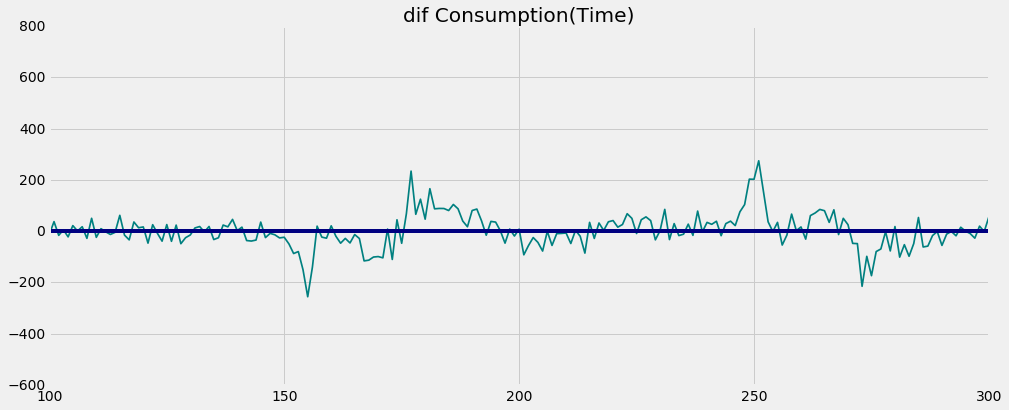

In [33]:
plt.figure(figsize=(15, 6))
plt.plot(Learn_Data_Cons.Time, Learn_Data_Cons.Consumption,color='teal',linewidth=1.7)
c=Learn_Data_Cons.Time
plt.xlim(100,300)
plt.plot(c,1.82713485*10**(-4)*c-0.469736517, color='navy')
plt.title("dif Consumption(Time)")
plt.show()

Убираем сезонность **по неделям**

In [34]:
Learn_Data_Cons.Consumption=pd.core.series.Series(Learn_Data_Cons.Consumption[i + 48*7] - 
                               Learn_Data_Cons.Consumption[i] for i in range(len(Learn_Data_Cons) - 48*7))
Learn_Data_Cons = Learn_Data_Cons[np.isfinite(Learn_Data_Cons['Consumption'])]

Consumption


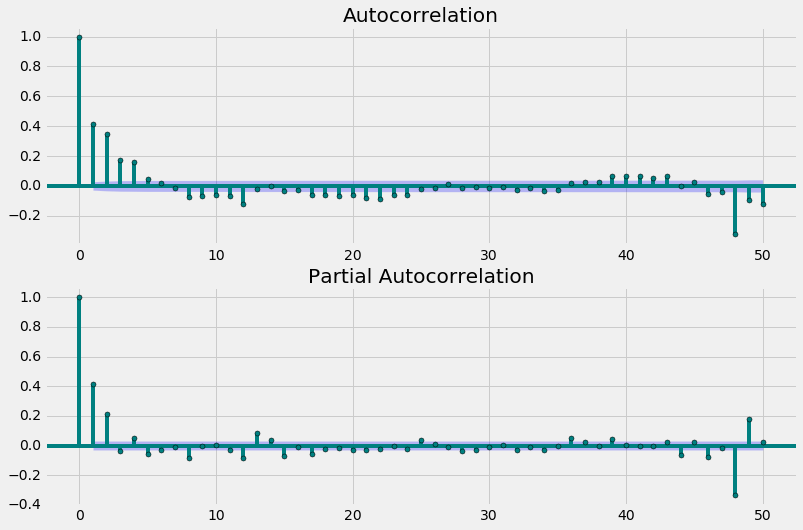

In [35]:
print("Consumption")
Draw_autcorrelation(Learn_Data_Cons.Consumption,c='teal')

Будем считать, что Consumption мы обработали. 
### Выполним аналогичные действия для температуры.

температура зависит только от времени дня. Также от времени года, но выборка у нас всего 115 дней. Поэтому будем дифференциировать по дням.

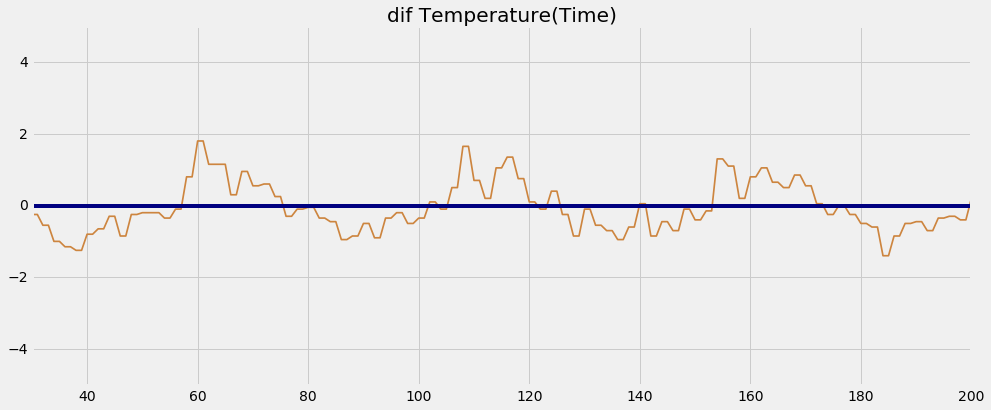

In [36]:
plt.figure(figsize=(15, 6))
plt.plot(Learn_Data_Temp.Time, Learn_Data_Temp.Temperature,color='peru',linewidth=1.7)
c=Learn_Data_Temp.Time
plt.xlim(30,200)
plt.ylim(-5,5)
plt.plot(c,-9.88869197*10**(-7)*c-1.46170425*10**(-3), color='navy')
plt.title("dif Temperature(Time)")
plt.show()

Длина периода для температуры напоминает **48 единиц.**

In [37]:
Learn_Data_Temp.Temperature=pd.core.series.Series(Learn_Data_Temp.Temperature[i + 48] - 
                               Learn_Data_Temp.Temperature[i] for i in range(len(Learn_Data_Temp) - 48))
Learn_Data_Temp = Learn_Data_Temp[np.isfinite(Learn_Data_Temp['Temperature'])]

Temperature


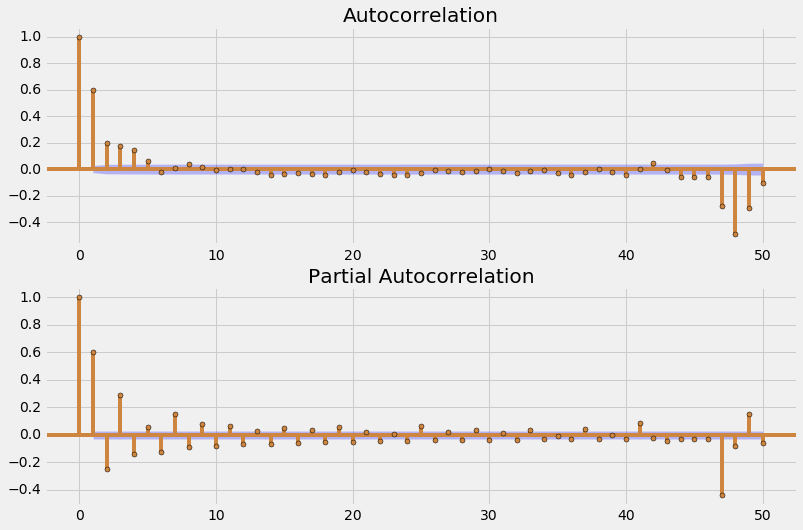

In [38]:
print("Temperature")
Draw_autcorrelation(Learn_Data_Temp.Temperature,c='peru')

Видим, что по каролелограммам можем выделить несколько наиболее значимых лагов, пренебрегая побочной сезонностью.
Что мы и сделаем в следующем шаге.

In [39]:
Learn_Data_Temp.Time=parse_data(Learn_Data_Temp.Time)

100%|██████████| 5134/5134 [04:19<00:00, 19.77it/s]


In [40]:
Learn_Data_Cons.Time=parse_data(Learn_Data_Cons.Time)

100%|██████████| 4798/4798 [03:54<00:00, 20.47it/s]


## Часть 5
### модель SARIMA

1) С помощью преобразований исходных рядов приведите их к стационарным. По графикам $ACF$ и $PACF$ подберите параметры модели $SARIMA$.
2) С помощью поиска по сетке вокруг выбранных параметров подберите оптимальные параметры по значению $AIC$. Учтите, что из сделанных ранее преобразований ряда нужно оставить лишь некоторые. Другие, например, одна из сезонностей будут учтены параметрами модели.

Класс, реализующий модель SARIMAX$(p, d, q) \times (P, D, Q)_s$

`class` <a href="http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html">`statsmodels.tsa.statespace.sarimax.SARIMAX`</a>`(endog, exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, measurement_error=False, time_varying_regression=False, mle_regression=True, simple_differencing=False, enforce_stationarity=True, enforce_invertibility=True, hamilton_representation=False, **kwargs)`

`endog` --- временной ряд

`exog` --- экзогенные факторы (регрессоры)

`order` = $(p, d, q)$

`seasonal_order` = $(P, D, Q, s)$

Метод `fit` --- обучение модели (оценка коэффициентов).

Если не работает `tqdm_notebook`, замените на `tqdm` или просто уберите его.

***Внимательнее изучим кароллелограммы и подберем наши начальные параметры для модели:***

Начальное приближение $q$: последний значимый пик у $ACF$ -- $q=0.2$
Начальное приближение $p$: последний значимый пик у $PACF$ -- $p=0.3$

In [41]:
p = range(1)
q = range(1)
d = [1]
P = range(4)
D = [1]
Q = range(3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 48) for x in list(itertools.product(P, D, Q))]

In [42]:
type(Learn_Data_Cons.Time)

pandas.core.series.Series

In [43]:
Learn_Data_Cons.Time=pd.to_datetime(Learn_Data_Cons.Time)
print(type(Learn_Data_Cons.Time[0]))

<class 'pandas._libs.tslib.Timestamp'>


In [44]:
Learn_Data_Cons

,Consumption,Time
0,-83.021597,2000-01-10 00:00:00
1,-43.620085,2000-01-10 00:30:00
2,-10.272155,2000-01-10 01:00:00
3,-20.772709,2000-01-10 01:30:00
4,-59.652780,2000-01-10 02:00:00
5,11.575783,2000-01-10 02:30:00
6,-11.880813,2000-01-10 03:00:00
7,20.255885,2000-01-10 03:30:00
8,21.994315,2000-01-10 04:00:00
9,33.380265,2000-01-10 04:30:00


In [1]:
Learn_Data_Cons=pd.Series(index=Learn_Data_Cons.Time,data=np.array(Learn_Data_Cons.Consumption))
Learn_Data_Cons=Learn_Data_Cons[:100]

NameError: name 'pd' is not defined

In [2]:
from tqdm import tqdm
for param in tqdm(pdq):
    for param_seasonal in tqdm(seasonal_pdq, leave=False):
        try:
            model = sm.tsa.statespace.SARIMAX(Learn_Data_Cons,order=param, seasonal_order=param_seasonal, 
                                              enforce_stationarity=False, enforce_invertibility=False)
            model = model.fit()
            print('ARIMA{}x{}12 – AIC:{}'.format(param, param_seasonal, model.aic))
        except:
            continue
print('=================')

NameError: name 'pdq' is not defined

In [3]:
warnings.filterwarnings('ignore')

for param in tqdm_notebook(pdq):
    for param_seasonal in tqdm_notebook(seasonal_pdq, leave=False):
        try:
            model = sm.tsa.statespace.SARIMAX(Learn_Data_Temp, order=param, seasonal_order=param_seasonal, 
                                              enforce_stationarity=False, enforce_invertibility=False)
            model = model.fit()
            print('ARIMA{}x{}12 – AIC:{}'.format(param, param_seasonal, model.aic))
        except:
            continue

NameError: name 'warnings' is not defined

***Конец входа:***

***Конец входа:***

***Конец входа:***